In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from gpplot import add_correlation
from core import med_log_odds_cutoff, high_log_odds_cutoff
from sklearn.linear_model import LogisticRegression
import joblib
from matplotlib_venn import venn2

In [2]:
plt.rcParams['font.size'] = 7
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
def get_percentile(x, percentile):
    x = x.dropna()
    if len(x):
        return np.percentile(x.dropna(), percentile)
    else:
        return pd.NA
    
def get_median(x):
    x = x.dropna()
    if len(x):
        return np.median(x.dropna())
    else:
        return pd.NA

In [4]:
insert_info = pd.read_csv('../data/raw/Beaker Validation Tracker 2.0 - v4.csv')
novel_insert_info = pd.read_csv('../data/raw/novel_domain_library.csv')
early_insert_info = pd.read_csv('../data/raw/Beaker Validation Tracker 2.0 - v5_rescreen.csv')
eop_data = pd.read_csv('../data/raw/24-03-28 EOP tracking - Systems.csv')
ecor_predictions = pd.read_csv('../data/interim/ecor_predictions.csv')

/state/partition1/slurm_tmp/27708111.0.0/ipykernel_378144/2394408564.py:5: DtypeWarning: Columns (21,27) have mixed types. Specify dtype option on import or set low_memory=False.
  ecor_predictions = pd.read_csv('../data/interim/ecor_predictions.csv')


### Concatenate library info 

In [5]:
cols = ['operon', 'working_id', 'description', 'cloned', 'screened LB', 'fp', 'pBAD']
# random
brief_insert_info = insert_info[cols].copy()
brief_insert_info['library'] = 'random'
# novel
brief_novel_insert_info = novel_insert_info.copy()
brief_novel_insert_info = brief_novel_insert_info.rename(columns = {'ID': 'operon'})
brief_novel_insert_info = brief_novel_insert_info[[x for x in cols if x not in ['fp', 'pBAD']]].copy()
brief_novel_insert_info['library'] = 'novel'
# early
brief_early_insert_info = early_insert_info.copy()
brief_early_insert_info[['cloned', 'screened LB']] = True, True
brief_early_insert_info = brief_early_insert_info[[x for x in cols if x not in ['fp', 'pBAD']]]
brief_early_insert_info['library'] = 'early'
# concatenate
brief_insert_info = pd.concat([brief_insert_info, brief_novel_insert_info, brief_early_insert_info]).reset_index(drop=True)
brief_insert_info['fp'] = brief_insert_info['fp'].fillna(0).astype(bool)
brief_insert_info['screened LB'] = brief_insert_info['screened LB'].fillna(False)
brief_insert_info['pBAD'] = brief_insert_info['pBAD'].fillna(False)
brief_insert_info = (brief_insert_info[brief_insert_info['screened LB'] | brief_insert_info['fp']]
                     .groupby(['operon', 'working_id', 'screened LB', 'fp', 'pBAD'])
                     .agg(library=('library', lambda x: ','.join(x)))
                     .reset_index())
brief_insert_info = brief_insert_info[~brief_insert_info['working_id'].isin(['AAA3', 'CRDO', 'HHHD'])]

In [6]:
brief_insert_info['library'].value_counts()

library
random          43
early           42
novel           17
random,novel     4
Name: count, dtype: int64

In [7]:
brief_insert_info['random'] = brief_insert_info['library'].str.contains('random')
brief_insert_info['curated'] = brief_insert_info['library'].str.contains('early|novel')
library_source_sum = brief_insert_info[['random', 'curated']].value_counts().reset_index()

In [8]:
library_source_sum

,random,curated,count
0,False,True,59
1,True,False,43
2,True,True,4


In [9]:
library_source_sum.query('random & ~curated')['count'].item()

43

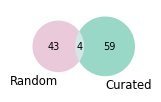

In [10]:
plt.subplots(figsize=(1.5, 1.5))
venn2(subsets={'10': library_source_sum.query('random & ~curated')['count'].item(), 
               '01': library_source_sum.query('~random & curated')['count'].item(), 
               '11': library_source_sum.query('random & curated')['count'].item()}, 
      set_labels=('Random', 'Curated'), 
      set_colors=('#CC79A7', '#009E73'))
plt.savefig('../figures/library_source_venn.svg', dpi=300, bbox_inches='tight')

In [11]:
exploded_insert_info = brief_insert_info.copy()
exploded_insert_info['split_operon'] = (exploded_insert_info['operon'].str.split(';'))
exploded_insert_info = exploded_insert_info.explode('split_operon')

In [12]:
merged_exploded_info = (exploded_insert_info.merge(ecor_predictions.rename(columns={'operon': 'split_operon'}), 
                                                   how='inner', on='split_operon'))

In [13]:
insert_predictions = (merged_exploded_info
                      .groupby(['operon', 'genomic_accession', 'assembly', 'strand'])
                      .agg(max_prediction = ('beaker_prediction', 'max'), 
                           min_prediction = ('beaker_prediction', 'min'), 
                           predictions=('beaker_prediction', lambda x: ', '.join([str(y) for y in x])), 
                           product_accessions=('product_accession', lambda x: ', '.join(x)), 
                           cds_start=('start', 'min'), 
                           cds_end=('end', 'max'), 
                           names=('name', lambda x: ', '.join(x)))
                      .reset_index())

In [14]:
insert_predictions.shape

(106, 11)

In [15]:
validated_systems = eop_data['System'].unique()

In [16]:
len(validated_systems)

45

In [17]:
merged_insert_info = (brief_insert_info.merge(insert_predictions, how='inner', on='operon'))
merged_insert_info['defensive'] = merged_insert_info['working_id'].isin(validated_systems)
merged_insert_info['max_log_odds'] = np.log(merged_insert_info['max_prediction']/(1-merged_insert_info['max_prediction']))
merged_insert_info['fp'] = merged_insert_info['fp'].fillna(0).astype(bool)
merged_insert_info['category'] = pd.Categorical(['Validated defense' if x else 'Not validated' for x in merged_insert_info['defensive']], 
                                                categories=['Validated defense', 'Not validated'])
merged_insert_info = (merged_insert_info
                      .sort_values('max_log_odds', ascending=False)
                      .reset_index(drop=True))


In [18]:
merged_insert_info.query('random')['defensive'].mean()

0.40425531914893614

In [19]:
merged_insert_info.query('curated')['defensive'].mean()

0.4603174603174603

In [20]:
merged_insert_info['category'].value_counts()

category
Not validated        61
Validated defense    45
Name: count, dtype: int64

In [21]:
(merged_insert_info['category'] == 'Validated defense').sum()/len(merged_insert_info)

0.42452830188679247

### Estimate validation rate

In [22]:
min_tpr_window = 5


In [23]:
precision_list = list()
for i, row in merged_insert_info.iterrows():
    if (i+1) >= min_tpr_window:
        filtered_merged_insert_info = merged_insert_info.iloc[0:(i+1), :]
        precision = filtered_merged_insert_info['defensive'].mean()
        precision_list.append(precision)
    else:
        precision_list.append(np.nan)

In [24]:
merged_insert_info['precision'] = precision_list

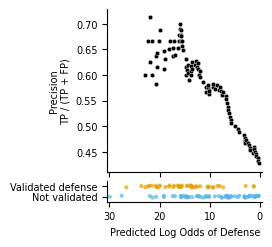

In [25]:
fig, (ax1, ax2) = plt.subplots(2,1,height_ratios=[4,0.5], figsize=(2,2.5), sharex=True)
fig.subplots_adjust(hspace=0.1)
sns.scatterplot(data=merged_insert_info, 
                x='max_log_odds', y='precision', ax=ax1, color='black', s=10)
sns.stripplot(data=merged_insert_info, y='category', x='max_log_odds', 
              ax=ax2, orient='h', alpha=0.7, hue='defensive', legend=False, 
              palette=['#56b4e9', '#e69f00'], jitter=True, dodge=False, s=3)
ax1.set_ylabel('Precision\nTP / (TP + FP)')
ax2.set_ylabel('')
ax2.set_xlabel('Predicted Log Odds of Defense')
sns.despine()
plt.xlim(merged_insert_info['max_log_odds'].max() + 0.5, -0.5)
plt.savefig('../figures/estimated_precision.svg', dpi=300, bbox_inches='tight')

In [26]:
top_preds = merged_insert_info.sort_values('max_log_odds', ascending=False).head(n=len(merged_insert_info)//2)
bottom_preds = merged_insert_info.sort_values('max_log_odds', ascending=True).head(n=len(merged_insert_info)//2)
print(top_preds['defensive'].mean())
print(bottom_preds['defensive'].mean())


0.6226415094339622
0.22641509433962265


In [27]:
log_odds_width = 4

In [28]:
ref_points = merged_insert_info['max_log_odds']
n_resamples = 1_000
range_def_frac_list = list()
neighbor_dist = log_odds_width/2
min_pts = 10
for i in tqdm(range(n_resamples)):
    resampled_df = merged_insert_info.sample(frac=1, replace=True, random_state=i)
    for mid_pt in ref_points:
        min_log_odds = mid_pt - neighbor_dist
        max_log_odds = mid_pt + neighbor_dist
        relevant_pts = resampled_df.loc[(resampled_df['max_log_odds'] > min_log_odds) & 
                                        (resampled_df['max_log_odds'] < max_log_odds)]
        n_pts = len(relevant_pts)
        if n_pts > min_pts:
            defensive_ratio = relevant_pts['defensive'].mean()
            range_def_frac_list.append({'trial': i, 
                                        'frac_defensive': defensive_ratio, 
                                        'n_pts': n_pts, 
                                        'mid_pt': mid_pt})
        

100%|██████████| 1000/1000 [01:03<00:00, 15.68it/s]


In [29]:
range_def_frac_df = pd.DataFrame(range_def_frac_list)
range_def_frac_sum = (range_def_frac_df.groupby('mid_pt')
                      .agg(precision_top=('frac_defensive', lambda x: get_percentile(x, 97.5)),
                           precision_bottom=('frac_defensive', lambda x: get_percentile(x, 2.5)), 
                           precision_median=('frac_defensive', lambda x: get_median(x)),
                           std_defense=('frac_defensive', 'std'), 
                           mean_n = ('n_pts', 'mean'), 
                           total_trials=('trial', 'nunique'))
                      .reset_index())

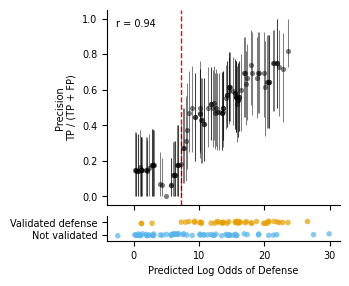

In [30]:
fig, (ax1, ax2) = plt.subplots(2,1,height_ratios=[4,0.5], figsize=(3,3), sharex=True)
fig.subplots_adjust(hspace=0.1)
ax1.errorbar(x=range_def_frac_sum['mid_pt'], y=range_def_frac_sum['precision_median'], 
             yerr=[range_def_frac_sum['precision_median'] - range_def_frac_sum['precision_bottom'], 
                   range_def_frac_sum['precision_top'] - range_def_frac_sum['precision_median']], 
             capsize=0, color='black', ms=7.5, elinewidth=0.75, fmt='.', alpha=0.5, markeredgewidth=0)
add_correlation(data=range_def_frac_sum, x='mid_pt', y='precision_median', ax=ax1, fontfamily='Sans-Serif')
ax1.axvline(x=med_log_odds_cutoff, linestyle='dashed', color='red', zorder=0, linewidth=1)
sns.stripplot(data=merged_insert_info, y='category', x='max_log_odds', 
              ax=ax2, orient='h', alpha=0.7, hue='defensive', legend=False, 
              palette=['#56b4e9', '#e69f00'], jitter=True, dodge=False, s=4)
sns.despine()
ax1.set_ylabel('Precision\nTP / (TP + FP)')
ax2.set_ylabel('')
ax2.set_xlabel('Predicted Log Odds of Defense')
plt.savefig('../figures/estimated_precision.svg', dpi=600, bbox_inches='tight')

In [31]:
from scipy import stats

In [32]:
stats.pearsonr(range_def_frac_sum['mid_pt'], 
               range_def_frac_sum['precision_median'])

PearsonRResult(statistic=0.9430060626036636, pvalue=1.3834136096468895e-49)

In [33]:
merged_insert_info.loc[merged_insert_info['max_log_odds'] < med_log_odds_cutoff, 'defensive'].mean()

0.09375

In [34]:
merged_insert_info.loc[(merged_insert_info['max_log_odds'] > med_log_odds_cutoff), 'defensive'].mean()

0.5675675675675675

In [35]:
med_log_odds_cutoff

7.1713435

In [36]:
pd.set_option('display.max_rows', 110)
range_def_frac_sum.sort_values('mid_pt')

,mid_pt,precision_top,precision_bottom,precision_median,std_defense,mean_n,total_trials
0,0.164578,0.360227,0.000000,0.150000,0.096109,14.318059,742
1,0.351036,0.360227,0.000000,0.150000,0.096109,14.318059,742
2,0.385249,0.352941,0.000000,0.142857,0.091586,14.855263,836
3,0.691981,0.352941,0.000000,0.142857,0.091586,14.855263,836
4,0.722949,0.352941,0.000000,0.142857,0.091586,14.855263,836
5,0.955197,0.375000,0.000000,0.166667,0.095300,17.130977,962
6,1.114860,0.333333,0.000000,0.150000,0.086386,19.011122,989
7,1.178630,0.333333,0.000000,0.150000,0.086386,19.011122,989
8,1.179123,0.333333,0.000000,0.150000,0.086386,19.011122,989
9,1.327825,0.333333,0.000000,0.150000,0.086386,19.011122,989


In [37]:
ref_points

0      29.941095
1      27.551983
2      26.621878
3      23.632707
4      22.832744
5      22.302809
6      21.992148
7      21.909117
8      21.487906
9      21.405088
10     20.728851
11     20.669274
12     20.599582
13     20.444088
14     20.097770
15     19.896411
16     19.159908
17     19.105135
18     18.808351
19     18.086522
20     17.955956
21     17.374407
22     17.246827
23     17.085618
24     16.920925
25     16.369538
26     16.130791
27     16.092312
28     15.971617
29     15.969485
30     15.798280
31     15.691585
32     15.683851
33     15.639481
34     15.570477
35     15.530167
36     15.247155
37     14.742400
38     14.653388
39     14.649203
40     14.560736
41     14.312058
42     14.302500
43     14.144954
44     13.725296
45     13.699525
46     13.623194
47     13.465957
48     13.463362
49     12.984917
50     12.770019
51     12.587263
52     12.408142
53     12.320312
54     12.162749
55     11.849431
56     11.835149
57     11.306706
58     10.7657

In [38]:
(merged_insert_info
 .groupby('defensive')
 .agg({'max_log_odds': ['mean', 'std']}))

max_log_odds          
                  mean       std
defensive                       
False         9.341672  7.216146
True         14.865032  5.752698

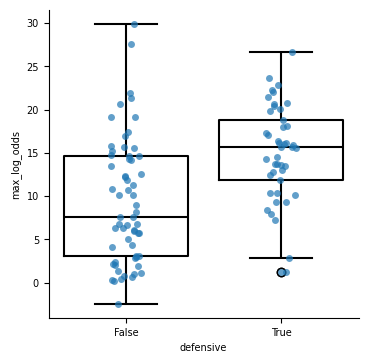

In [39]:
plt.subplots(figsize=(4,4))
sns.boxplot(data=merged_insert_info, x='defensive', y='max_log_odds', fill=False, 
            color='black')
sns.stripplot(data=merged_insert_info, x='defensive', y='max_log_odds', 
              alpha=0.7,  jitter=True, dodge=False)
sns.despine()

In [40]:
precision_transfomer = LogisticRegression(random_state=0).fit(merged_insert_info[['max_log_odds']], 
                                                              merged_insert_info['defensive'])
precision_transfomer.predict_proba(pd.DataFrame({'max_log_odds': [-30,-20,-10, 0, 10, 20, 30]}))[:,1]

array([0.00406025, 0.01381918, 0.0459518 , 0.1420386 , 0.3626688 ,
       0.66169602, 0.87051526])

In [41]:
joblib.dump(precision_transfomer, '../models/logistic_log_odds2precision.pkl')

['../models/logistic_log_odds2precision.pkl']

In [42]:
merged_insert_info.drop(columns='precision').to_csv('../data/interim/all_library_info.csv', index=False)